# Simulation 3 - Number of Distinct Conditions and Overlapping Perturbations

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
from src import utils, sims, plots, tests

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

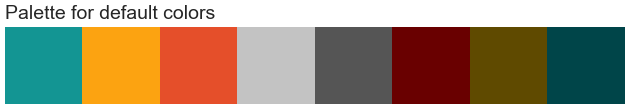

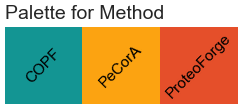

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]
method_palette = {
    "COPF": "#139593",
    "PeCorA": "#fca311",
    "ProteoForge": "#e54f2a",
}
method_styles = {
    "COPF": "--",
    "PeCorA": "-.",
    "ProteoForge": ":",
}
method_markers = {
    "COPF": "o",
    "PeCorA": "s",
    "ProteoForge": "^",
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)
plots.color_palette(
    method_palette, 
    name = "Method",
    save=False
)

In [3]:
notebook_name = "Sim3"
data_path = "./data/generated/"
input_path = "./data/exp/"
output_path = f"./data/exp/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

# Create the Simulated Data

## Initial Data

### Global Variables for the Simulation


In [4]:
## Global Variables
pthr = 10**-3
cur_method = "WLR"
method_title = "Weighted Least Squares"
formula = 'adjIntensity ~ Condition * allothers'
thresholds = list(utils.generate_thresholds(10.0, -15, 1, 0, 1, 0.1))

# Parameters
seed=42                         # Seed for reproducibility
n_proteins = 500                # Number of proteins in the dataset
n_replicates = 10               # Number of replicates per condition
n_peptides = (5, 50)            # (min, max) for peptides per protein
nPro_to_perturb = 250           # Number of proteins to perturbs
pertMag_range = (.5, 1.5)       # Range of values to perturb the peptides with (uniform)

In [5]:
stTime = utils.getTime()
# Number of conditions to generate (with shifts)
conditions = {
    2: [0, .5],
    3: [0, .5, 1],
    4: [0, .5, 1, 1.5],
    5: [0, .5, 1, 1.5, 2],
}
for n_condition, condition_shifts in conditions.items():
    ## Generate the data

    # Create Protein Mean Values
    mean_values = sims.normal_distribution_with_outliers(
        mu = 20,  
        sd = 2,  
        size = n_proteins, 
        is_log2=False, 
        outlier_fraction=0.10, 
        outlier_sd_multiplier=1.0, 
        seed=seed
    )
    mean_values = 2**mean_values

    # Create Protein CV Values
    cv_values = sims.lognormal_distribution(
        mu=10,
        med=8,
        size=n_proteins,
        seed=seed
    )

    # Generate replicates to have a biological sample as reference
    control_data = sims.generate_replicates(
        mean_values, 
        cv_values,
        meanScale="raw",
        cvType="percent", 
        nReps=n_replicates, 
        randomizeCV=True,
        as_dataframe=True, 
        seed=seed
    )

    # Generate the number of peptides per protein
    pepN_cnts = sims.generate_peptide_counts(
        n_proteins=n_proteins,
        min_peptides=n_peptides[0],
        max_peptides=n_peptides[1],
        alpha=.5, 
        beta=3,
    )

    # Generate the peptide level data using the protein level data 
    pep_data = sims.generate_peptide_level(
        control_data,
        pepN_cnts,
        is_log2=False,         
        repStd=(0.1, 0.25),
        outlier_fraction=0.0001,
        outlier_multiplier=0.01,
        add_noise=True,
        noise_sd=0.10,
        seed=seed
    )

    # Generate Condition Mappers to be utilized later on
    condition_sample_map, condition_palette, sample_palette, condition_shifts = sims.generate_condition_mappers(
        n_condition=n_condition-1,
        n_replicates=n_replicates,
        condition_shifts=condition_shifts[1:],
        control_name="control",
        control_color="#8d99ae",
        condition_suffix="cond-",
        condition_palette="Blues",
    )

    # Generate the complete peptide level data with all conditions
    # Copy the peptide data to create the condition data
    complete_data = sims.generate_complete_data(
        pep_data,
        condition_shifts=condition_shifts,
        condition_sample_map=condition_sample_map,
        shift_scale=0.10,
        is_log2=False,
        add_noise=False,
        noise_sd=0.10,
        seed=seed
    )
    # Get the conditions to perturb
    perturb_conds = list(condition_sample_map.keys())[1:]
    # Get the unique proteins
    unique_proteins = complete_data.reset_index()["Protein"].unique()
    # Run for Overlap and Non-Overlap variants
    for pertType in [True, False]:
        isOverlap = "Overlap" if pertType else "NonOverlap"
        nPep_to_perturb = -1            # Number of peptides to perturb if > 1 then it is a fraction
        perturb_dir_setup = "same"    # Randomly perturb the direction of the perturbation [random, same]
        simulated_data = complete_data.copy()
        
        # Select random proteins to perturb
        proteins_to_perturb = np.random.choice(unique_proteins, nPro_to_perturb, replace=False)

        # Pick a fraction between 0.1 and 0.5 of the peptides to perturb
        if nPep_to_perturb == -1:
            nPep_array = np.random.uniform(0.1, 0.5, len(unique_proteins))
        elif nPep_to_perturb < 1 and nPep_to_perturb > 0:
            nPep_array = np.repeat(nPep_to_perturb, len(unique_proteins))
        elif nPep_to_perturb >= 1:
            nPep_array = np.repeat(nPep_to_perturb, len(unique_proteins))

        # Subset the data for perturbation
        tmp = np.log2(simulated_data).copy()
        perturb_data = tmp.loc[proteins_to_perturb]
        unchanged_data = tmp.drop(proteins_to_perturb)

        # Go through the proteins and perturb single peptide in each
        dictCnt = 0
        perturbation_map = {}
        for i, protein in enumerate(proteins_to_perturb):
            cur_data = perturb_data.loc[protein]
            if nPep_to_perturb < 1:
                n = int(nPep_array[i] * len(cur_data))
                # Ensure minimum of 1 peptide is perturbed
                if n < 2: n = 2
            elif nPep_to_perturb >= 1:
                n = int(nPep_to_perturb)
            # print(f"Protein: {protein} - Peptides: {n}, Total Peptides: {len(cur_data)}")
            pepNums = np.random.choice(cur_data.index, n, replace=False)
            if isOverlap:
                # Get the perturbation magnitude for the peptides
                pertMag = np.random.uniform(pertMag_range[0], pertMag_range[1], (len(pepNums), len(perturb_conds)))
                if perturb_dir_setup == "random":
                    pertDir = np.random.choice([-1, 1], (len(pepNums), len(perturb_conds)), replace=True)
                elif perturb_dir_setup == "same":
                    # Pick random direction
                    pertDir = np.random.choice([-1, 1], 1, replace=True)
                    pertDir = np.repeat(pertDir, len(pepNums) * len(perturb_conds)).reshape((len(pepNums), len(perturb_conds)))
                pertCond = perturb_conds
            else:
                # Get the perturbation magnitude for the peptides
                pertMag = np.random.uniform(pertMag_range[0], pertMag_range[1], len(pepNums))
                # Pick a random condition to perturb for each pro
                pertCond = np.random.choice(perturb_conds, 1)
                if perturb_dir_setup == "random":
                    pertDir = np.random.choice([-1, 1], len(pepNums), replace=True)
                elif perturb_dir_setup == "same":
                    # Pick random direction
                    pertDir = np.random.choice([-1, 1], 1, replace=True)
                    pertDir = np.repeat(pertDir, len(pepNums))

            # Using pertMag and pertDir
            perturb_shift = pertMag * pertDir
            # Select peptides and conditions to perturb
            for j, cond in enumerate(pertCond):
                perturb_value = perturb_shift[:, j]
                perturb_samples = condition_sample_map[cond]
                # Get the perturbation peptide intensity
                perturb_intensity = cur_data.loc[pepNums, perturb_samples]
                # Update the perturbation peptide intensity
                perturb_intensity += perturb_value[:, np.newaxis]
                perturb_data.loc[(protein, pepNums), perturb_samples] = perturb_intensity.values


            perturbation_map.update({
                dictCnt + p: {
                    "Protein": protein,
                    "Peptide": peptide,
                    "pertCondition": perturb_conds,
                    "pertShift": perturb_shift[p, :]
                }
                for p, peptide in enumerate(pepNums)
            })
            dictCnt += len(pepNums)

        # Combine the perturbed and unchanged data
        perturbed_data = pd.concat([perturb_data, unchanged_data], axis=0)
        perturbed_data = (np.power(2, perturbed_data))

        missing_data = sims.amputation(
            data = perturbed_data,
            unique_proteins = unique_proteins,
            proteins_to_perturb = proteins_to_perturb,
            condition_shifts = condition_shifts,
            condition_sample_map = condition_sample_map,
            n_amputate_1 = 50,
            n_amputate_2 = 100,
            n_amputate_3 = 50,
            missing_rate = 0.25,
            seed = seed
        )

        imputed_data = sims.downshifted_imputation(
            data = missing_data,
            condition_sample_map = condition_sample_map,
            is_log2 = False,
            shiftMag = 2,
            lowPct = 0.15,
            minValue = 8,
            impute_all = False,
            seed = seed
        )
        test_data = sims.build_test_data(
            data = imputed_data,
            condition_sample_map = condition_sample_map,
            perturbation_map = perturbation_map,
            proteins_to_perturb = proteins_to_perturb,
            missing_data = missing_data,
        )

        feather.write_dataframe(
            test_data,
            f"{output_path}{n_condition}Cond_{isOverlap}_InputData.feather"
        )

print( 
    f"Time to generate the simulated scenarios to test: ",
    utils.prettyTimer( utils.getTime() - stTime)
)

Time to generate the simulated scenarios to test:  00h:01m:21s


# Calculating the Benchmarking on Missingness Rates

## ProteoForge

In [6]:
save_plots = True
stTime = utils.getTime()
cur_method = 'ProteoForge'
for n_condition, condition_shifts in conditions.items():
    for pertType in [True, False]:
        isOverlap = "Overlap" if pertType else "NonOverlap"
        # Load the data
        cur_data = feather.read_dataframe(
            f"{output_path}{n_condition}Cond_{isOverlap}_InputData.feather"
        )
        ## Run the ProteoForge method
        results = sims.apply_ProteoForge(
            data = cur_data,
            formula = formula,
            protein_col = "Protein",
            peptide_col = "Peptide",
            weight_col = "Weight",
            comparison_col = "allothers",
            correction_method = "fdr"
        )
        # Save the results
        feather.write_dataframe(
            results,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_ModelResults.feather"
        )
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
                label_col="pertPeptide",
                pvalue_col="adj.pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title = f"Peptide Identification Benchmark of {cur_method} \n({n_condition} Conditions, Overlap: {isOverlap})",
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}_{n_condition}Cond_{isOverlap}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )
        ## Run the protein grouping benchmarks
        metricData = sims.benchmark_ProteoForge_grouping(
            data = results,
            thresholds = thresholds,
            pvalue_col = "adj.pval",
            protein_col = "Protein",
            cluster_col = "cluster_id",
            perturbation_col = "pertPFG",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_PFGBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title = f"Protein Grouping Benchmark of {cur_method} \n({n_condition} Conditions, Overlap: {isOverlap})",
                save = True,
                dont_show = True,
                filename = f"PFGBenchmarks_{cur_method}_{n_condition}Cond_{isOverlap}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )
print(
    f"Time to run the ProteoForge method and benchmarks: ",
    utils.prettyTimer( utils.getTime() - stTime)
)

Time to run the ProteoForge method and benchmarks:  00h:06m:52s


## PeCorA

### Run the Model

In [7]:
# Run the PeCorA methoon the different missingness rates
!Rscript runPeCorA_Sim3.R {notebook_name}

Running PeCorA on the simulated data in Sim3 folder
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 7.43 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the interaction p-values"
  |======================================================================| 100%[1] " "
[1] "PeCorA finished in 23.22 minutes"
[1] "number of proteins tested = 500"
[1] "number of peptides tested = 5582"
[1] "started making data table"
[1] "correcting p-values"
[1] "number of uncorrelated peptides = 530"
[1] "number of proteins with uncorrelated peptides = 307"
Saving the proteoform results into a feather file... 
[1] "scaling peptides to control == 0"
  |======================================================================| 100%[1] " "
[1] "peptide scaling completed in 7.63 minutes"
[1] "checking which proteins still have at least 2 peptides"
[1] "computing the i

### Evaluate the Model with Benchmarking Data

In [8]:
save_plots = True
cur_method = 'PeCorA'
print(f"Benchmarking {cur_method} for condition and overlap scenarios")

for n_condition, condition_shifts in conditions.items():
    for pertType in [True, False]:
        isOverlap = "Overlap" if pertType else "NonOverlap"
        # Load the data
        results = feather.read_dataframe(
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_ModelResults.feather"
        )
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
                label_col="pertPeptide",
                pvalue_col="adj_pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title = f"Peptide Identification Benchmark of {cur_method} \n({n_condition} Conditions, Overlap: {isOverlap})",
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}{n_condition}Cond_{isOverlap}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

Benchmarking PeCorA for condition and overlap scenarios


## COPF

### Run the Model

In [9]:
# Run the COPF method on the different missingness rates
!Rscript runCOPF_Sim3.R {notebook_name}

No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating proteoform scores... 
Saving the proteoform results into a feather file... 
No protein mass annotation found, PCprofiler continues without mass annotation.
Data placed into trace structure from ccprofiler 5583 rows and 4 columns.
Running the clustering... 
Calculating 

### Evaluate the Model with Benchmarking Data

In [10]:
save_plots = True
cur_method = 'COPF'
# Collect Results from the simulations 
print(f"Benchmarking {cur_method} for the different missingness rates")

for n_condition, condition_shifts in conditions.items():
    for pertType in [True, False]:
        isOverlap = "Overlap" if pertType else "NonOverlap"
        # Load the data
        results = feather.read_dataframe(
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_ModelResults.feather"
        )
        ## Run the the peptide identification benchmarks
        metricData = utils.create_metric_data(
            results,
            pvalue_thresholds = thresholds,
                label_col="pertPeptide",
                pvalue_col="pval",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_PepIDBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title = f"Peptide Identification Benchmark of {cur_method} \n({n_condition} Conditions, Overlap: {isOverlap})",
                save = True,
                dont_show = True,
                filename = f"PepIDBenchmarks_{cur_method}{n_condition}Cond_{isOverlap}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )
        ## Run the protein grouping benchmarks
        metricData = sims.benchmark_COPF_grouping(
            data = results,
            thresholds = thresholds,
            pvalue_col = "pval",
            protein_col = "Protein",
            cluster_col = "cluster",
            perturbation_col = "pertPFG",
        )
        # Save the data
        feather.write_dataframe(
            metricData,
            f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_PFGBenchmarks.feather"
        )
        if save_plots:
            # Plots a WLR Metrics
            _ = plots.combined_curves(
                metricData,
                pthr=pthr,
                prScore='MCC',
                title = f"Protein Grouping Benchmark of {cur_method} \n({n_condition} Conditions, Overlap: {isOverlap})",
                save = True,
                dont_show = True,
                filename = f"PFGBenchmarks_{cur_method}{n_condition}Cond_{isOverlap}",
                filepath = figure_path,
                fileformats = figure_formats,
                dpi = figure_dpi,
                transparent = transparet_bg,
            )

Benchmarking COPF for the different missingness rates


# Benchmark the Simulation Together 

## Put together the Benchmark Data

In [11]:
from importlib import reload
reload(tests)
reload(plots)
reload(utils)
reload(sims);

In [12]:
id_benchmark_name = "PepIDBenchmarks.feather"
grp_benchmark_name = "PFGBenchmarks.feather"
# Load the benchmark data
idBenchmarkData = pd.DataFrame()
grpBenchmarkData = pd.DataFrame()
methods = ["COPF", "PeCorA", "ProteoForge"]
for n_condition, condition_shifts in conditions.items():
    for pertType in [True, False]:
        isOverlap = "Overlap" if pertType else "NonOverlap"
        for cur_method in methods:
            ## PepIDBenchmark Combines
            cur_path = f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_{id_benchmark_name}"
            cur_data = feather.read_dataframe(cur_path).assign(
                Condition = n_condition,
                Overlap = isOverlap,
                Method = cur_method
            )
            idBenchmarkData = pd.concat([idBenchmarkData, cur_data], ignore_index=True)
            ## PFGBenchmark Combines
            if cur_method == 'PeCorA':
                continue
            
            cur_path = f"{output_path}{n_condition}Cond_{isOverlap}_{cur_method}_{grp_benchmark_name}"
            cur_data = feather.read_dataframe(cur_path).assign(
                Condition = n_condition,
                Overlap = isOverlap,
                Method = cur_method
            )
            grpBenchmarkData = pd.concat([grpBenchmarkData, cur_data], ignore_index=True)     

print(f"Identification Benchmark Data shape: {idBenchmarkData.shape}")
print(f"Grouping Benchmark Data shape: {grpBenchmarkData.shape}")       

Identification Benchmark Data shape: (600, 15)
Grouping Benchmark Data shape: (400, 15)


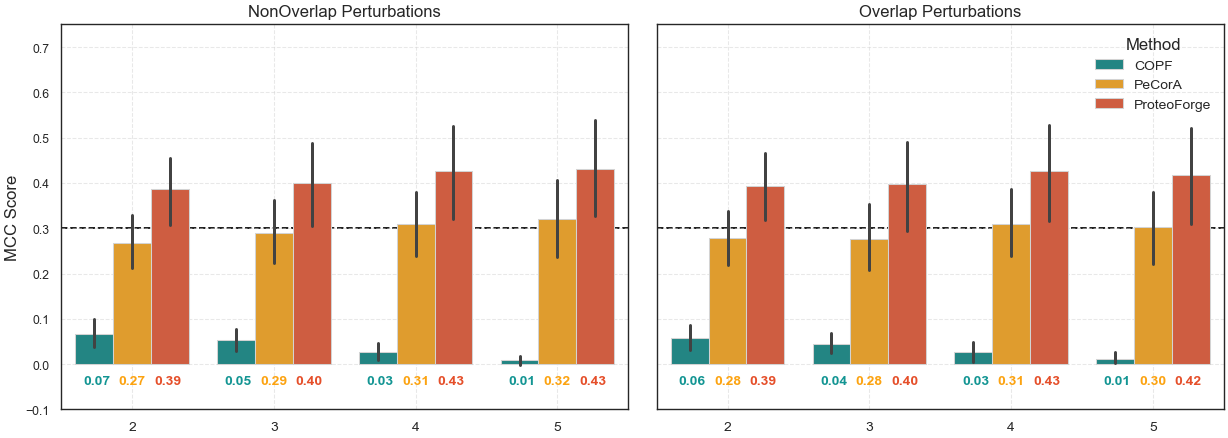

In [13]:
# Create subplots for MCC Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(
    1, 2, figsize=(15, 5), 
    sharey=True, sharex=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.1}
)
nconds = list(conditions.keys())
overlaps = ["NonOverlap", "Overlap"]
for i, isOverlap in enumerate(overlaps):
    cur_data = idBenchmarkData[idBenchmarkData["Overlap"] == isOverlap]
    sns.barplot(
        ax=axes[i],
        data=cur_data,
        x="Condition",
        y="MCC",
        hue="Method",
        # errorbar=('se', 0.95),
        palette=method_palette,
        edgecolor="lightgrey",
        linewidth=0.75,
    )
    # Write the average MCC score for each method on the top of the bars
    for j, condition in enumerate(nconds):
        for k, method in enumerate(methods):
            cur_score = cur_data[
                (cur_data["Condition"] == condition) & 
                (cur_data["Method"] == method)
            ]["MCC"].mean()
            axes[i].text(
                j + k * 0.25 - 0.25,
                0 - 0.05,
                f"{cur_score:.2f}",
                color=method_palette[method],
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )
    axes[i].set_title(f"{isOverlap} Perturbations", fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylim(-0.1, .75)
    axes[i].axhline(0.3, color="black", linestyle="--", linewidth=1.25, zorder=0)
    axes[i].grid("y", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=10)
    # If first subplot, set the ylabel
    if i == 0:
        axes[i].set_ylabel("MCC Score", fontsize=12)
        # Remove the legend for the first subplot
        axes[i].legend().set_visible(False)

    else:
        axes[i].set_ylabel("")
        axes[i].legend(loc='upper right', title="Method", fontsize=10, title_fontsize=12, frameon=False)
plt.tight_layout()
# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj=plt.gcf(),
        filename=f"IdentificationBenchmark_MCCScore_ConditionswithOverlap",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

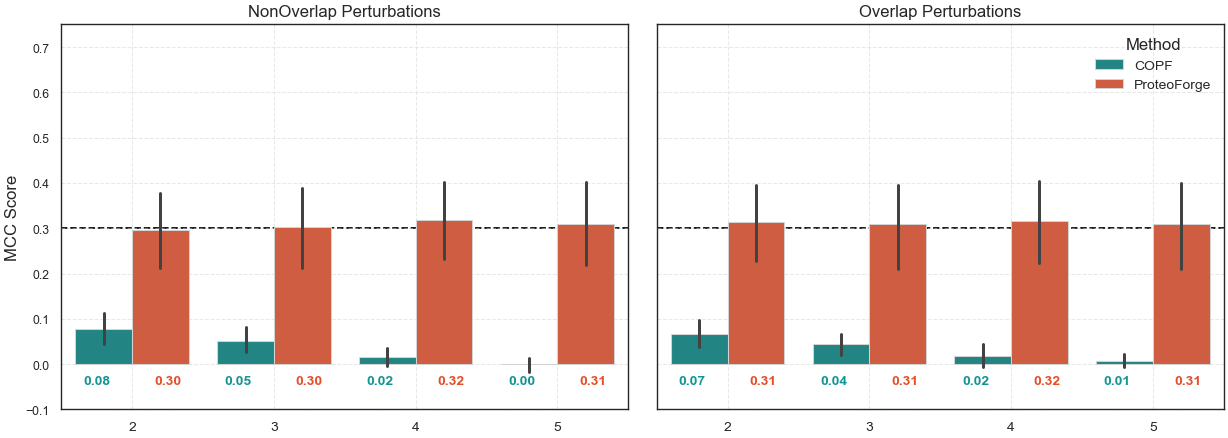

In [14]:
# Create subplots for MCC Score for different perturbations and methods at the best threshold
fig, axes = plt.subplots(
    1, 2, figsize=(15, 5), 
    sharey=True, sharex=True,
    gridspec_kw={"wspace": 0.05, "hspace": 0.1}
)
nconds = list(conditions.keys())
overlaps = ["NonOverlap", "Overlap"]
for i, isOverlap in enumerate(overlaps):
    cur_data = grpBenchmarkData[grpBenchmarkData["Overlap"] == isOverlap]
    sns.barplot(
        ax=axes[i],
        data=cur_data,
        x="Condition",
        y="MCC",
        hue="Method",
        # errorbar=('se', 0.95),
        palette=method_palette,
        edgecolor="lightgrey",
        linewidth=0.75,
    )
    # Write the average MCC score for each method on the top of the bars
    for j, condition in enumerate(nconds):
        for k, method in enumerate(methods):
            if method == "PeCorA":
                continue
            cur_score = cur_data[
                (cur_data["Condition"] == condition) & 
                (cur_data["Method"] == method)
            ]["MCC"].mean()
            axes[i].text(
                j + k * 0.25 - 0.25,
                0 - 0.05,
                f"{cur_score:.2f}",
                color=method_palette[method],
                ha="center",
                va="bottom",
                fontsize=10,
                fontweight="bold",
            )
    axes[i].set_title(f"{isOverlap} Perturbations", fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylim(-0.1, .75)
    axes[i].axhline(0.3, color="black", linestyle="--", linewidth=1.25, zorder=0)
    axes[i].grid("y", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=10)
    # If first subplot, set the ylabel
    if i == 0:
        axes[i].set_ylabel("MCC Score", fontsize=12)
        # Remove the legend for the first subplot
        axes[i].legend().set_visible(False)

    else:
        axes[i].set_ylabel("")
        axes[i].legend(loc='upper right', title="Method", fontsize=10, title_fontsize=12, frameon=False)
plt.tight_layout()
# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj=plt.gcf(),
        filename=f"GroupingBenchmark_MCCScore_ConditionswithOverlap",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )